## **Notebook Summary**

### **Purpose**
This notebook evaluates and visualizes the performance of a clinical trial-patient matching system ("trial_matches.json"), comparing system-assigned trial suitability verdicts against curated gold-standard labels.

---

### **Key Steps and Logic**

#### **1. Data Loading**
- Loads:
  - **Gold/reference** patient-trial pairs and scores from `test.tsv`.
  - **Patient queries** and **trial corpus** from `queries.jsonl` and `corpus.jsonl`.
  - **Trial matches** (detailed matching outputs) from `matched/trial_matches.json` (contains verdicts, reasoning about inclusion/exclusion).

#### **2. Flatten & Normalize Trial Matches**
- Iterates through `trial_matches.json` to **flatten nested structures** into a DataFrame:
  - Columns include: `query-id`, `corpus-id`, model trial verdict (`match_verdict`), reasoning, inclusion/exclusion flags, and detailed eligibility explanations.

#### **3. Merge Gold with System Predictions**
- Merges gold-standard pairs (`df_tsv`) with matched verdicts (`df_trial_matches`) by query and trial IDs.
- Ensures **all gold pairs are present**, filling unmatched ones with NaN for later filtering/checks.

#### **4. Label Harmonization**
- Maps system verdicts (“STRONG MATCH”, “POSSIBLE MATCH”, “WEAK MATCH”, “UNSUITABLE”) into numeric label space {0, 1, 2} for comparison:
  - 2: Highly likely ("STRONG MATCH" or "POSSIBLE MATCH")
  - 1: Would consider ("WEAK MATCH")
  - 0: Would not refer ("UNSUITABLE")
- Aligns ground-truth labels from gold file into the same space.

#### **5. Evaluation**
- **Omissions:** Reports count/samples of pairs where there is no system verdict (excluded from scoring).
- **Metrics:**
  - Computes **confusion matrix** (tabular and heatmap) to visualize agreement.
  - Calculates **macro-averaged F1 score** and displays a full classification report (precision/recall per label).
- **Visualization:** Plots the confusion matrix with Seaborn for a clear model performance summary.

#### **6. Inspection & Quality Control**
- Provides options to display merged/evaluated DataFrame (with explanations/reasoning), as well as any omitted/missing rows.

#### **7. Display/Output**
- Configures pandas for wide displays, allowing direct inspection of large slices of merged data and reasoning fields.

---

### **Outputs**
- **Metrics for Model QA:** Confusion matrix, macro F1, precision/recall for each decision level.
- **Visualization:** Color-coded confusion matrix heatmap for rapid error pattern assessment.
- **Inspection:** Full merged DataFrame can be displayed, supporting qualitative analysis via system reasoning and verdicts.

---

### **Intended Use**
- **Model validation and debugging:** Evaluate system-patient-to-trial assignment quality.
- **Insight into errors:** Directly reveals misclassifications and their reasoning by exploring DataFrame rows.
- **Transparent reporting:** Well-suited for sharing system strengths and weaknesses with stakeholders or during clinical IR system development.

---

### **Technical/Architectural Notes**
- **Robust merging:** Ensures all reference pairs are considered, not just those found by the matcher.
- **Extendable:** Can be easily fit for other datasets or more granular scoring/justification analysis.
- **User-friendly:** Designed for rapid exploratory analysis, including straightforward displays for both summary and raw data.

In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
# Set pandas display options 
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 400)

In [3]:
import os
import pandas as pd
import json

# Set up paths
DATA_DIR = "../data/sigir2016/processed_cut"
MATCHED_DIR = "../data/sigir2016/matched"

TSV_FILE = os.path.join(DATA_DIR, "test.tsv")
QUERIES_FILE = os.path.join(DATA_DIR, "queries.jsonl")
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.jsonl")
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load main input data
df_tsv = pd.read_csv(TSV_FILE, sep='\t')
df_queries = pd.read_json(QUERIES_FILE, lines=True)
df_corpus = pd.read_json(CORPUS_FILE, lines=True)

In [4]:
print(f" df_tsv {len(df_tsv)} df_queries {len(df_queries)} df_corpus {len(df_corpus)}")

 df_tsv 3870 df_queries 59 df_corpus 3626


In [5]:
# Glimpse at dataframes:
display(df_tsv.head())
display(df_queries.head())
display(df_corpus.head())
# display(trial_matches_long.head())

# ---- Now you can proceed with analysis & evaluation below!

,query-id,corpus-id,score
0,sigir-20141,NCT00000408,0
1,sigir-20141,NCT00000492,1
2,sigir-20141,NCT00000501,0
3,sigir-20141,NCT00001853,0
4,sigir-20141,NCT00004727,0


,_id,text
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is not increased on inspiration. The latest episode of pain ended half an hour prior to her arrival. Sh..."
1,sigir-20142,"An 8-year-old male presents in March to the ER with fever up to 39 C, dyspnea and cough for 2 days. He has just returned from a 5 day vacation in Colorado. Parents report that prior to the onset of fever and cough, he had loose stools. He denies upper respiratory tract symptoms. On examination he is in respiratory distress and has bronchial respiratory sounds on the left. A chest x-ray shows b..."
2,sigir-20143,"A 58-year-old nonsmoker white female with mild exertional dyspnea and occasional cough is found to have a left lung mass on chest x-ray. She is otherwise asymptomatic. A neurologic examination is unremarkable, but a CT scan of the head shows a solitary mass in the right frontal lobe."
3,sigir-20144,"A 2-year-old boy is brought to the emergency department by his parents for 5 days of high fever and irritability. The physical exam reveals conjunctivitis, strawberry tongue, inflammation of the hands and feet, desquamation of the skin of the fingers and toes, and cervical lymphadenopathy with the smallest node at 1.5 cm. The abdominal exam demonstrates tenderness and enlarged liver. Laborator..."
4,sigir-20145,A 56-year-old female on 20th day post-left mastectomy presents to the emergency department complaining of shortness of breath and malaise. The patient says that she has remained in bed for the last two weeks. The physical examination reveals tenderness on the left upper thoracic wall and right calf. The surgical incision shows no bleeding or signs of infection. Pulmonary auscultation is signif...


,_id,title,metadata
0,NCT00000369,Maintenance Therapies in Bipolar Disorders,"{'phase': 'Phase 3', 'drugs': '['Individual psychotherapy', 'Lithium carbonate']', 'drugs_list': ['Individual psychotherapy', 'Lithium carbonate'], 'diseases_list': ['Bipolar Disorder'], 'enrollment': '0', 'inclusion_criteria': 'Patients must have: Acute bipolar I illness and be experiencing a manic or depressed episode at the time of study entry. Required: Current treatment with lithium carbo..."
1,NCT00000402,Calcium and Bone Mass in Young Females,"{'phase': 'Phase 2', 'drugs': '['Calcium']', 'drugs_list': ['Calcium'], 'diseases_list': ['Osteoporosis'], 'enrollment': '354', 'inclusion_criteria': '- Pubertal stage II - Calcium intake below a threshold level - Caucasian - Normal health', 'exclusion_criteria': '- Medications affecting calcium and bone metabolism - Chronic diseases - Metabolic bone disease - Abnormality in calcium metabolism..."
2,NCT00000408,Low Back Pain Patient Education Evaluation,"{'phase': 'N/A', 'drugs': '['Patient education evaluation']', 'drugs_list': ['Patient education evaluation'], 'diseases_list': ['Low Back Pain'], 'enrollment': '580', 'inclusion_criteria': '- Must live in the United States - Must understand and write English - Must have access to a computer with e-mail and expect to have this access for at least 3 years - Must be 18 years old - Must have seen ..."
3,NCT00000430,Low-Dose Hormone Replacement Therapy and Alendronate for Osteoporosis,"{'phase': 'Phase 3', 'drugs': '['Alendronate', 'Estrogen/progestin therapy']', 'drugs_list': ['Alendronate', 'Estrogen/progestin therapy'], 'diseases_list': ['Osteopenia', 'Osteoporosis'], 'enrollment': '240', 'inclusion_criteria': '- Women at least 60 years of age. - Good general health. - Willingness to participate in this 3.5 year study. - Ability to give informed consent. - Ability to live..."
4,NCT00000432,Lyme Disease Prevention Program,"{'phase': 'Phase 3', 'drugs': '['Education about disease prevention']', 'drugs_list': ['Education about disease prevention'], 'diseases_list': ['Lyme Disease', 'Tick-Borne Diseases'], 'enrollment': '20000', 'inclusion_criteria': '- Ferry passengers traveling to Nantucket Island', 'exclusion_criteria': '- Foreign (non-U.S.) residence', 'brief_summary': 'This is a large study of an educational p..."


In [6]:
TRIAL_MATCHES_FILE = os.path.join(MATCHED_DIR, "trial_matches.json")

# Load the JSON as a list of dicts
with open(TRIAL_MATCHES_FILE, "r") as f:
    trial_matches = json.load(f)

# Flattening loop
records = []
for patient_dict in trial_matches:
    patient_id = patient_dict['patient_id']
    for eval_ in patient_dict['trial_evaluations']:
        trial_id = eval_['trial_id']
        trial_title = eval_.get('trial_title')
        scoring = eval_.get('scoring_result', {})
        inclusion = eval_.get('inclusion_result', {})
        exclusion = eval_.get('exclusion_result', {})
        records.append({
            'query-id': patient_id,
            'corpus-id': trial_id,
            'trial_title': trial_title,
            # From scoring_result
            'score': scoring.get('score'),
            'match_verdict': scoring.get('verdict'),
            'match_reasoning': scoring.get('reasoning'),
            # From exclusion_result
            'exclusion_verdict': exclusion.get('verdict'),
            'exclusion_reason': exclusion.get('reason'),
            # From inclusion_result
            'inclusion_verdict': inclusion.get('verdict'),
            'inclusion_missing_info': inclusion.get('missing_information'),
            'inclusion_unmet_criteria': inclusion.get('unmet_criteria'),
            'inclusion_reasoning': inclusion.get('reasoning'),
        })

# Create DataFrame
df_trial_matches = pd.DataFrame(records)

# Preview
pd.set_option('display.max_colwidth', 200)
display(df_trial_matches.head())

,query-id,corpus-id,trial_title,score,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning
0,sigir-20141,NCT02357212,Early Invasive Versus Conservative Therapy in Women With an Acute Coronary Syndrome,60,POSSIBLE MATCH,"The patient's presentation with chest pain suggestive of acute coronary syndrome and the absence of clear exclusionary factors based on the provided history make this a possible match. However, th...",PASS,Patient does not meet any exclusion criteria. The patient's profile does not provide clear evidence of meeting any of the exclusion criteria listed for the trial. There is no mention of ST-elevati...,UNDETERMINED,- Elevated troponin T levels\n- Elevated creatinine kinase MB-isoenzyme levels\n- Elevated NT-pro-BNP levels\n- ST-segment depression measurement\n- TIMI risk score,None,"The patient is a 58-year-old female presenting with episodic pressing/burning anterior chest pain that started two days earlier, accompanied by nausea, diaphoresis, and mild dyspnea. This presenta..."
1,sigir-20141,NCT01682096,Pilot Safety Study of Coronary CTA for the Diagnosis of Acute Coronary Syndrome in the Emergency Room,70,POSSIBLE MATCH,"The patient's presentation with chest pain and nonspecific EKG changes, in the context of an intermediate pre-test probability of coronary artery disease, makes them a potential candidate for this...",PASS,"Patient does not meet any exclusion criteria. Although the patient presents with episodic pressing/burning anterior chest pain, which could suggest cardiac issues, there is no clear evidence in th...",UNDETERMINED,- The patient's current rhythm (whether in sinus rhythm)\n- The duration of the chest pain in the last 24 hours\n- Estimated pre-test probability of significant coronary artery disease\n- Specific...,None,"The patient presents with episodic pressing/burning anterior chest pain that started two days earlier, which could align with the criterion of typical or atypical chest pain. However, the duration..."
2,sigir-20141,NCT01084239,Multicenter Study to Rule Out Myocardial Infarction by Cardiac Computed Tomography,None,None,None,PASS,"Patient does not meet any exclusion criteria. Although the patient presents with chest pain suggestive of potential cardiac issues, there is no clear evidence provided in the patient summary that ...",FAIL,"None\nUNMET CRITERIA: \n1. Criterion 1 is partially met as the patient had chest pain, but the duration and timing in relation to ED presentation are not clearly within 24 hours.\n2. Criterion 2 i...","1. Criterion 1 is partially met as the patient had chest pain, but the duration and timing in relation to ED presentation are not clearly within 24 hours.\n2. Criterion 2 is not met as the patient...","The patient's profile indicates that she had chest pain, which aligns with part of the first criterion. However, the information provided does not clearly establish that this pain occurred within ..."
3,sigir-20141,NCT01665521,Efficacy Evaluation of the HEART Pathway in Emergency Department Patients With Acute Chest Pain,80,STRONG MATCH,The patient's presentation with chest pain suggestive of possible ACS and the absence of clear exclusion criteria based on the provided information make this patient a strong match for the trial. ...,PASS,"Patient does not meet any exclusion criteria. The patient's profile does not provide clear evidence of new ST-segment elevation, unstable vital signs, terminal diagnosis, non-cardiac medical illne...",INCLUDE,None,None,"The patient's age is 58, which meets the criterion of being greater than or equal to 21 years. The patient's chief complaint of episodic pressing/burning anterior chest pain, accompanied by nausea..."
4,sigir-20141,NCT00536224,Chest Pain Observation Unit Risk Reduction Trial,80,STRONG MATCH,The patient's presentation with chest pain and presence of modifiable cardiovascular risk factors (hypertension and ob

In [7]:
len(df_trial_matches)

7434

In [8]:
# df_tsv: gold/reference pairs
# df_trial_matches: detailed match+reasoning info from trial_matches.json

# Merge, keeping all gold standard pairs and including trial_matches info when available:
merged_df = df_tsv.merge(df_trial_matches, on=['query-id', 'corpus-id'], how='left')

In [10]:
# Cell 1: True label 2, prediction available
df_true2_pred = merged_df[(merged_df["score_x"] == 2) & (merged_df["predicted_label"] == 2)]
display(df_true2_pred)
print(f"Rows: {len(df_true2_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
172,sigir-201410,NCT01599195,2,Use of Amplified Sound Signal to Identify Presence of Carotid and Femoral Stenosis,80,STRONG MATCH,"The patient's clinical presentation suggests a strong alignment with the trial's focus on femoral arterial stenosis, given the physical findings and recent cardiac catheterization. The presence of...",PASS,"Patient does not meet any exclusion criteria. The patient's age is 67 years, which falls within the allowed age range of 19 to 90 years as specified in the trial's exclusion criteria. Therefore, t...",INCLUDE,None,None,"The patient's age is 67 years, which falls within the specified range of 19-90 years. Additionally, the patient has had a recent procedure involving the femoral artery (cardiac catheterization via...",2.0,2
259,sigir-201412,NCT00715572,2,Combined Therapy With L-Thyroxine and L-Triiodothyronine Compared to L-Thyroxine Alone,80,STRONG MATCH,"The patient presents with symptoms suggestive of hypothyroidism, and the demographic information (age and gender) aligns well with the trial's inclusion criteria. While there are concerns regardin...",PASS,"Patient does not meet any exclusion criteria. The patient is 25 years old, which suggests she is likely premenopausal, and there is no mention of pregnancy, major comorbidity, or use of drugs that...",UNDETERMINED,- Laboratory results confirming reduced T4 concentration and increased TSH concentration.\n- Information on whether the patient has received thyroid hormones.,None,"The patient is a premenopausal woman, which aligns with the first part of the inclusion criteria. Her symptoms are consistent with hypothyroidism, but without explicit laboratory results (T4 and T...",2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,sigir-20157,NCT01682785,2,Incidence of Metabolic Syndrome and Thyroid Dysfunction in Patients With Major Depressive Disorder,80,STRONG MATCH,The patient's symptoms suggest a strong alignment with the trial's focus on Major Depressive Disorder. The lack of significant medical history and current medications reduces the likelihood of con...,PASS,"Patient does not meet any exclusion criteria. The exclusion criterion states that a subject who cannot give information should be excluded. However, there is no indication in the patient's profile...",UNDETERMINED,- Confirmation of major depressive disorder diagnosis,"- None, but potential concern regarding the lack of explicit diagnosis of major depressive disorder","The patient's symptoms such as increased sleep and appetite, difficulty concentrating, loss of enjoyment in social activities, and feelings of guilt could be indicative of major depressive disorde...",2.0,2
3758,sigir-20157,NCT02023567,2,The Establishment of the Objective Diagnostic Markers and Personalized Medical Intervention in Patients With Major Depressive Disorders (MDD),80,STRONG MATCH,The patient's symptoms and lack of significant medical history suggest a strong match for the trial. The alignment between the patient's condition (MDD) and the trial's focus on MDD is a key facto...,PASS,No exclusion criteria specified,UNDETERMINED,None,None,No inclusion criteria specified,2.0,2


Rows: 152


In [11]:
# Cell 2: True label 1, prediction available
df_true1_pred = merged_df[(merged_df["score_x"] == 1) & (merged_df["predicted_label"] == 1)]
display(df_true1_pred)
print(f"Rows: {len(df_true1_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
15,sigir-20141,NCT00149227,1,Add-on Effects of Valsartan on Morbi- Mortality (KYOTO HEART Study),40,WEAK MATCH,"The patient's eligibility for the KYOTO HEART Study is questionable due to the lack of clear alignment with key inclusion criteria, particularly the presence of significant risk factors beyond hyp...",PASS,"Patient does not meet any exclusion criteria. Although the patient presents with episodic pressing/burning anterior chest pain accompanied by nausea, diaphoresis, and mild dyspnea, which could sug...",INCLUDE,None,None,"The patient has a clinical diagnosis of hypertension, which meets the first inclusion criterion. Additionally, the patient has obesity (BMI > 25), which is considered a risk factor according to th...",1.0,1
22,sigir-20141,NCT00225355,1,Rosiglitazone Versus Placebo in Chronic Stable Angina,40,WEAK MATCH,"The patient's presentation suggests possible angina, but the lack of a confirmed diagnosis and missing information about previous exercise tolerance tests and current medications raises significan...",PASS,"Patient does not meet any exclusion criteria. The patient's profile does not indicate diabetes mellitus, liver failure, renal failure, cardiac failure (specifically NYHA 3 and 4), physical disabil...",UNDETERMINED,- Previous positive exercise tolerance test results\n- Disease suitability for coronary intervention (Coronary artery bypass grafting or angioplasty)\n- Body mass index (BMI) value or confirmation...,None,"The patient's chief complaint of episodic pressing/burning anterior chest pain could be indicative of angina, but the information provided does not confirm that it is chronic stable angina. Additi...",1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,sigir-20158,NCT02447614,1,Follow-up Studies of Primary Snoring(PS) and Obstructive Sleep Apnea Hypopnea Syndrome(OSAHS) in Chinese Children,70,POSSIBLE MATCH,"The patient's presentation of nighttime snoring and related symptoms suggests a possible diagnosis of OSAHS, which aligns with the trial's objectives. However, the lack of detailed medical history...",PASS,"Patient does not meet any exclusion criteria. The patient's symptoms of nighttime snoring, pauses in breathing, restlessness, and nighttime awakenings, along with excessive sleepiness, lack of att...",INCLUDE,None,None,"The patient is 10 years old, which falls within the specified age range of 3-12 years. The patient's chief complaint includes nighttime snoring, which aligns with the criterion of being referred f...",1.0,1
3816,sigir-20158,NCT02562040,1,Pediatric Adenotonsillectomy for Snoring,60,POSSIBLE MATCH,"The patient's symptoms suggest a possible alignment with the trial's objectives, but the lack of critical information regarding medical history, vital signs, and current medications raises concern...",PASS,Patient does not meet any exclusion criteria. The provided patient summary does not contain clear evidence that the patient meets any of the specified exclusion criteria. There is no mention of pr...,UNDETERMINED,- Obstructive apnea index (OAI) and apnea-hypopnea index (AHI) values to confirm the diagnosis of mild sleep-disordered breathing (MSDB)\n- Frequency of parental-reported habitual snoring\n- Tonsi...,None,"The patient's profile mentions symptoms consistent with sleep-disordered breathing, such as nighttime snoring, pauses in breathing, and excessive sleepiness. However, crucial details necessary to ...",1.0,1


Rows: 235


In [12]:
# Cell 3: True label 0, prediction available
df_true0_pred = merged_df[(merged_df["score_x"] == 0) & (~merged_df["predicted_label"].isna())]
display(df_true0_pred)
print(f"Rows: {len(df_true0_pred)}")

,query-id,corpus-id,score_x,trial_title,score_y,match_verdict,match_reasoning,exclusion_verdict,exclusion_reason,inclusion_verdict,inclusion_missing_info,inclusion_unmet_criteria,inclusion_reasoning,predicted_label,true_label
25,sigir-20141,NCT00337116,0,Intravenous Isosorbide Dinitrate Versus Sublingual Isosorbide Dinitrate for the Relief of Acute Anginal Episodes in Acute Coronary Syndrome (ACS) Patients,40,WEAK MATCH,"The patient's presentation suggests a possible acute coronary syndrome, but the lack of a clear diagnosis, specific ECG findings, and pain assessment on the VAS scale raises significant concerns a...",PASS,"Patient does not meet any exclusion criteria. The patient's profile does not provide clear evidence of meeting any of the exclusion criteria listed. Specifically, there is no mention of persistent...",UNDETERMINED,- Admission status to the ICCU with ACS (non-ST elevation acute coronary syndrome or 24 hours after ST elevation myocardial infarction)\n- Presence of ischemic symptoms (>=5 minutes) during hospit...,None,"The patient's age (58 years) meets the first inclusion criterion. However, there is insufficient information to determine if the patient meets the other criteria, such as admission to the ICCU wit...",1.0,0
37,sigir-20141,NCT00536224,0,Chest Pain Observation Unit Risk Reduction Trial,80,STRONG MATCH,The patient's presentation with chest pain and presence of modifiable cardiovascular risk factors (hypertension and obesity) make them a strong candidate for this trial. The trial's focus on brief...,PASS,"Patient does not meet any exclusion criteria. Although the patient presents with symptoms suggestive of myocardial ischemia (episodic pressing/burning anterior chest pain accompanied by nausea, di...",INCLUDE,None,None,"The patient's medical history indicates the presence of hypertension and obesity, both of which are modifiable cardiovascular risk factors as specified in the trial inclusion criteria. Although th...",2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3855,sigir-20159,NCT01661491,0,Microbiome Acquisition and Progression of Inflammation and Airway Disease in Infants and Children With Cystic Fibrosis,0,UNSUITABLE,"The patient's profile does not align with the trial's requirements for several critical reasons. Firstly, the disease alignment is off because the patient does not have a diagnosis of Cystic Fibro...",PASS,"Patient does not meet any exclusion criteria. The exclusion criteria mention ""Major organ system disease other than Cystic Fibrosis"" and ""History of prematurity"" for non-Cystic Fibrosis control pa...",UNDETERMINED,- Laboratory diagnosis or confirmation of Cystic Fibrosis,"- None, as the information is not present to confirm whether the criterion is met or not.",The trial requires a laboratory diagnosis of Cystic Fibrosis for inclusion. The patient's summary provides details on symptoms and laboratory results that could be indicative of various conditions...,0.0,0
3862,sigir-20159,NCT02134652,0,Ability of Bedside Ultrasound to Predict Progression of Severity of Disease in Dengue Fever,40,WEAK MATCH,"The patient's presentation with fever and other non-specific symptoms could suggest a variety of diagnoses, including but not limited to Dengue fever. The lack of a clear diagnosis of Dengue fever...",PASS,"Patient does not meet any exclusion criteria. The patient's profile does not indicate an allergy to ultrasound gel, there is no mention of the patient being a prisoner or ward of the state, the pa...",INCLUDE,None,None,"The patient's age is 10 years, which falls within the specified range of >3 months and <16 years, meeting criterion 1. The clinical presentation (myalgia, cough, shortness of breath, cyanosis, per...",1.0,0


Rows: 504


In [13]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Only use rows with non-missing score_y and score_x
yx = merged_df.loc[(~merged_df['score_y'].isna()) & (~merged_df['score_x'].isna()), ['score_y', 'score_x']]
score_y = yx['score_y'].values.astype(int)  # model output
score_x = yx['score_x'].values.astype(int)  # true labels

results = []
for cut1 in range(1, 100):
    for cut2 in range(cut1 + 1, 101):
        preds = np.digitize(score_y, bins=[cut1, cut2])  # (0, 1, 2)
        macro_f1 = f1_score(score_x, preds, labels=[0, 1, 2], average="macro")
        f1_1 = f1_score(score_x, preds, labels=[1], average=None)[0]
        f1_2 = f1_score(score_x, preds, labels=[2], average=None)[0]
        results.append({
            "cut1": cut1,
            "cut2": cut2,
            "macro_f1": macro_f1,
            "f1_1": f1_1,
            "f1_2": f1_2
        })

results_df = pd.DataFrame(results)

# Find maxima
best_macro = results_df.loc[results_df['macro_f1'].idxmax()]
best_1 = results_df.loc[results_df['f1_1'].idxmax()]
best_2 = results_df.loc[results_df['f1_2'].idxmax()]



Best cutpoints for macro F1: cut1=41, cut2=71, F1=0.5200
                            precision    recall  f1-score   support

        0) Would not refer       0.65      0.68      0.67       504
1) Would consider referral       0.47      0.37      0.41       404
 2) Highly likely to refer       0.44      0.53      0.48       285

                  accuracy                           0.54      1193
                 macro avg       0.52      0.53      0.52      1193
              weighted avg       0.54      0.54      0.54      1193

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,345,87,72
1) Would consider referral,137,148,119
2) Highly likely to refer,50,83,152


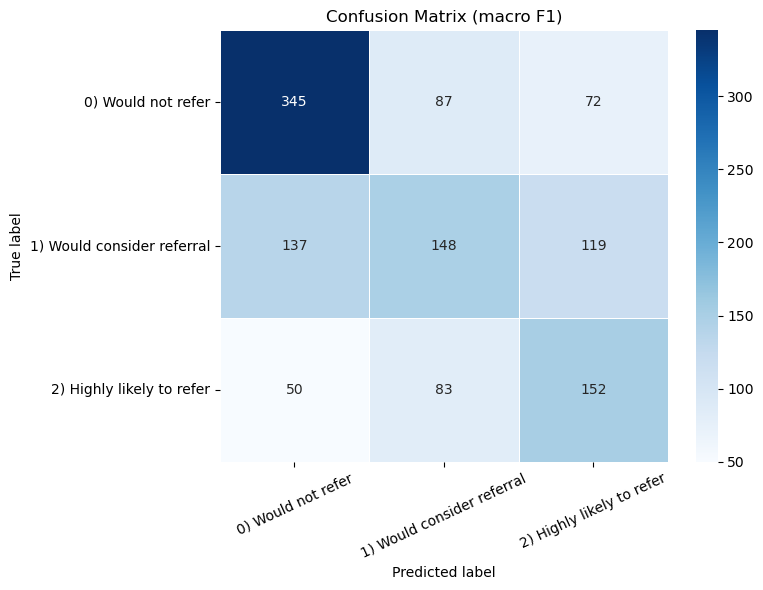


Best cutpoints for score 1 (Would consider): cut1=30, cut2=86, F1=0.5431
                            precision    recall  f1-score   support

        0) Would not refer       0.76      0.44      0.56       504
1) Would consider referral       0.40      0.87      0.54       404
 2) Highly likely to refer       0.70      0.05      0.09       285

                  accuracy                           0.49      1193
                 macro avg       0.62      0.45      0.40      1193
              weighted avg       0.62      0.49      0.44      1193

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,220,282,2
1) Would consider referral,50,350,4
2) Highly likely to refer,18,253,14


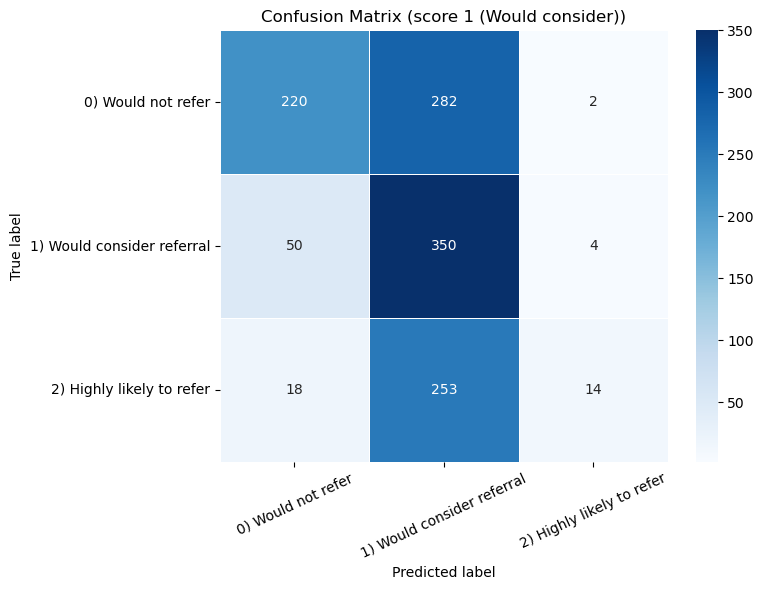


Best cutpoints for score 2 (Highly likely): cut1=1, cut2=41, F1=0.4968
                            precision    recall  f1-score   support

        0) Would not refer       0.94      0.06      0.12       504
1) Would consider referral       0.27      0.33      0.30       404
 2) Highly likely to refer       0.36      0.82      0.50       285

                  accuracy                           0.34      1193
                 macro avg       0.52      0.41      0.30      1193
              weighted avg       0.57      0.34      0.27      1193

Confusion Matrix:


,0) Would not refer,1) Would consider referral,2) Highly likely to refer
0) Would not refer,31,314,159
1) Would consider referral,2,135,267
2) Highly likely to refer,0,50,235


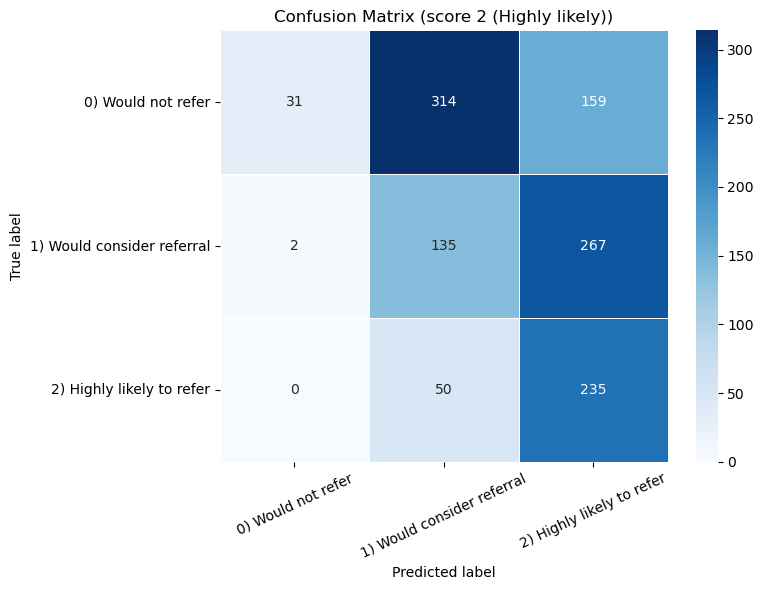

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

cut_labels = [
    "0) Would not refer",
    "1) Would consider referral",
    "2) Highly likely to refer"
]

def display_results_with_plot(cut1, cut2, label, f1val):
    preds = np.digitize(score_y, bins=[cut1, cut2])
    print(f"\nBest cutpoints for {label}: cut1={cut1}, cut2={cut2}, F1={f1val:.4f}")
    print(classification_report(
        score_x, preds, labels=[0, 1, 2],
        target_names=cut_labels
    ))
    cm = confusion_matrix(score_x, preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm, index=cut_labels, columns=cut_labels)
    print("Confusion Matrix:")
    display(cm_df)

    # Blue Confusion Matrix Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix ({label})')
    plt.yticks(rotation=0)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# Show results and blue CM for each optimal cutpoint set
display_results_with_plot(int(best_macro.cut1), int(best_macro.cut2), "macro F1", best_macro.macro_f1)
display_results_with_plot(int(best_1.cut1), int(best_1.cut2), "score 1 (Would consider)", best_1.f1_1)
display_results_with_plot(int(best_2.cut1), int(best_2.cut2), "score 2 (Highly likely)", best_2.f1_2)